In [1]:
import os
import sys
import time
import random
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import contextlib
import logging
import rdkit

from random import randrange
from rdkit import Chem, RDLogger
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem import AllChem, rdMolAlign, Descriptors, Draw
from rdkit.Chem.rdchem import Mol
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import rdFMCS, MolFromSmarts
from selfies import encoder, decoder 
from rdkit.Chem.Draw import MolToImage, IPythonConsole, rdMolDraw2D

import lomap

import fingerprint
import generation
import filters
import scoring
import visualization

# Ignore warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# set seed
#random.seed(42)
#np.random.seed(42)

In [2]:
# set perts to investigate in this list. make sure tgt/ligand names are correct because these strings are used to 
# parse ./ligands/.

perts_to_intrap = [
    ["tyk2", "ejm_54~ejm_31"], # start with a few easy FEPs.
    ["tyk2", "ejm_42~ejm_44"],
    ["tyk2", "ejm_44~ejm_31"],
    
    #["tyk2", "jmc_27~ejm_54"], # now try a few ring jumps.
    #["tyk2", "ejm_43~ejm_47"],
    #["tyk2", "ejm_49~ejm_45"],
    #["tnks2", "5p~5m"],
    #["tnks2", "1b~3a"],
    
    #["tnks2", "1a~8a"], # charge jumps probably out of scope.
    
    #["eg5", "CHEMBL1084678~CHEMBL1085666"], # some challenging multi-R-group ones.
    #["eg5", "CHEMBL1077227~CHEMBL1096002"], 
    #["eg5", "CHEMBL1082249~CHEMBL1085666"],
    
    #["galectin", "07_ligOH~05_ligOEt"], # tests a large MCS
    
    #["cats", "CatS_165~CatS_132"],  # also large MCS, but also large transform.
    #["cats", "CatS_29~CatS_141"], # mostly interested in seeing what happens to sulfoxide
    #["jnk1", "18635-1~18636-1"], # another MCS check. This transformation is already as 'small as can be'
    #["jnk1", "18627-1~18625-1"], # what if the transformation is already small as can be; but also just para->ortho?
    #["jnk1", "18634-1~18659-1"], # together with next; do both directions (A->B/B->A) result in same intermediate?
    #["jnk1", "18659-1~18634-1"],
    ["bace_combination", "03_biphenyl~02_biphenyl"],
    #["bace_combination", "03_biphenyl~06_biphenyl"],
    #["bace_combination", "04_biphenyl~05_biphenyl"],
    #["bace_combination", "03_biphenyl~11_spirocycles"],
    #["bace_combination", "03_biphenyl~45_amide_series"],
    #["bace_combination", "45_amide_series~11_spirocycles"],
                ]

In [3]:
# variables for generation

num_tries = 2 # Number of path/chemical path attempts between the exact same smiles
num_random_smiles = 1 # Number of different SMILES string orderings to consider for starting_smile & target_smile
collect_bidirectional = True
fp_type="ECFP4"
num_random_samples = 1000     # number of generated intermediates per mutation in the local chemical space generation
num_mutation_ls    = [1, 2]   # number of mutations per molecule in the local chemical space generation
n_rounds = 1      # number of rounds in the path-based generation

base_dir = f'/dfs4/dmobley-lab/djiskoot/gdrive/intermediates/bace/main_intermediates_selfies/testfolderx' # location to save images of pairs with intermediates


total number of path based generated intermediates:  108
total number of path based generated intermediates after filters:  2
Number of unique top1-scoring intermediates:  1
Randomized molecules (in SELFIES) time:  0.2944610118865967
Mutation obtainment time (back to smiles):  2.409977674484253
Unique mutated structure obtainment time:  0.29140520095825195
Fingerprint calculation time:  0.24160003662109375
Total time:  3.2377264499664307
total number of generated local chemical space intermediates for smiles-pair:  1761
total number of generated local chemical space intermediates after filters for smiles-pair:  6

total number of unique generated local chemical space intermediates:  6


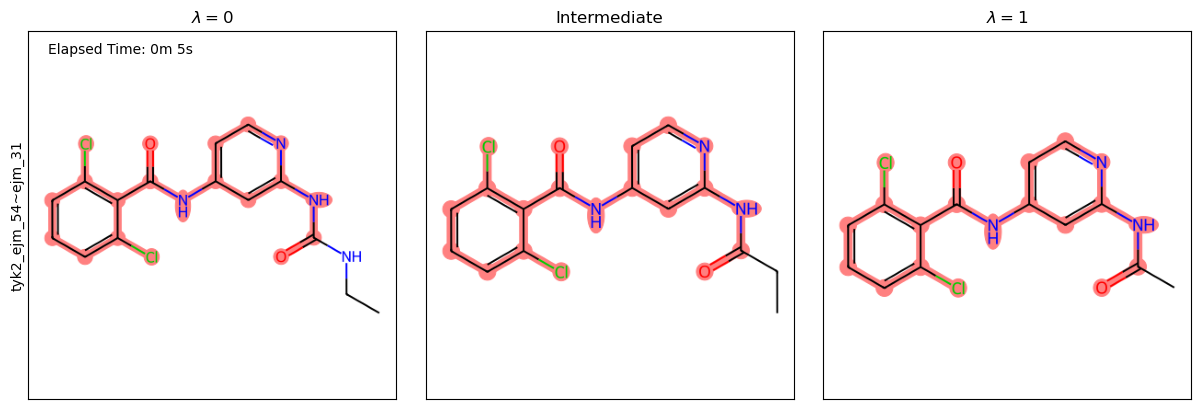

total number of path based generated intermediates:  136
total number of path based generated intermediates after filters:  2
Number of unique top1-scoring intermediates:  1
Randomized molecules (in SELFIES) time:  0.36468505859375
Mutation obtainment time (back to smiles):  2.6751017570495605
Unique mutated structure obtainment time:  0.3325796127319336
Fingerprint calculation time:  0.2666306495666504
Total time:  3.6393320560455322
total number of generated local chemical space intermediates for smiles-pair:  1778
total number of generated local chemical space intermediates after filters for smiles-pair:  14

total number of unique generated local chemical space intermediates:  14


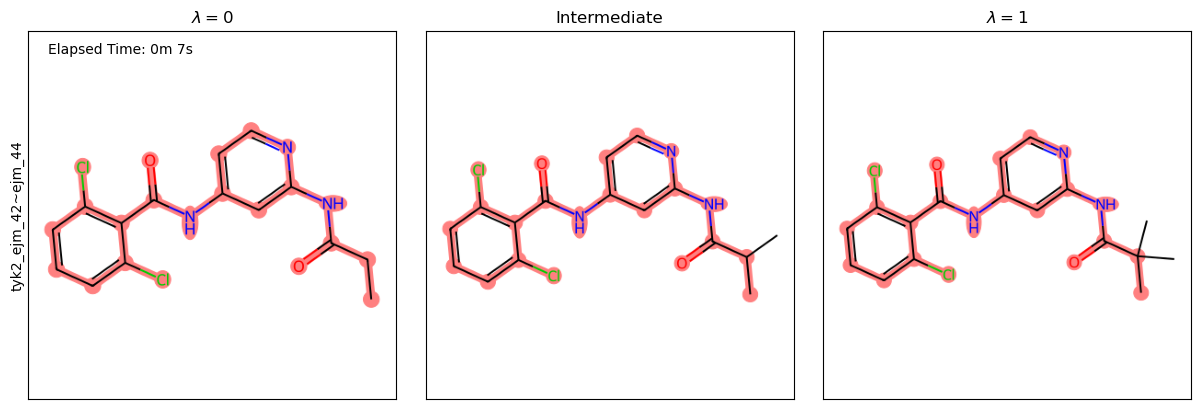

total number of path based generated intermediates:  116
total number of path based generated intermediates after filters:  3
Number of unique top1-scoring intermediates:  1
Randomized molecules (in SELFIES) time:  0.34056949615478516
Mutation obtainment time (back to smiles):  2.6967854499816895
Unique mutated structure obtainment time:  0.32892513275146484
Fingerprint calculation time:  0.2675173282623291
Total time:  3.6341583728790283
total number of generated local chemical space intermediates for smiles-pair:  1790
total number of generated local chemical space intermediates after filters for smiles-pair:  22

total number of unique generated local chemical space intermediates:  22


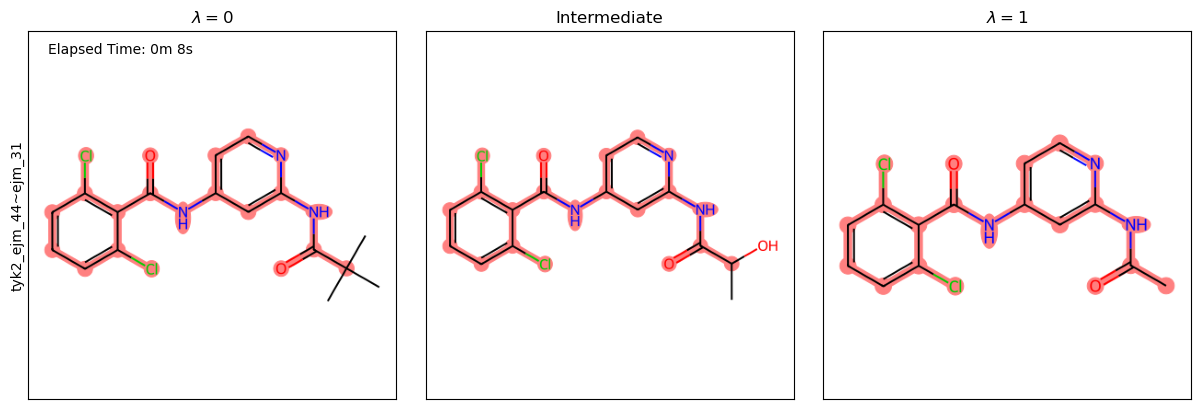

total number of path based generated intermediates:  144
total number of path based generated intermediates after filters:  3
Number of unique top1-scoring intermediates:  1
Randomized molecules (in SELFIES) time:  0.3653233051300049
Mutation obtainment time (back to smiles):  3.4076671600341797
Unique mutated structure obtainment time:  0.3741898536682129
Fingerprint calculation time:  0.3212707042694092
Total time:  4.468748569488525
total number of generated local chemical space intermediates for smiles-pair:  1891
total number of generated local chemical space intermediates after filters for smiles-pair:  37

total number of unique generated local chemical space intermediates:  37


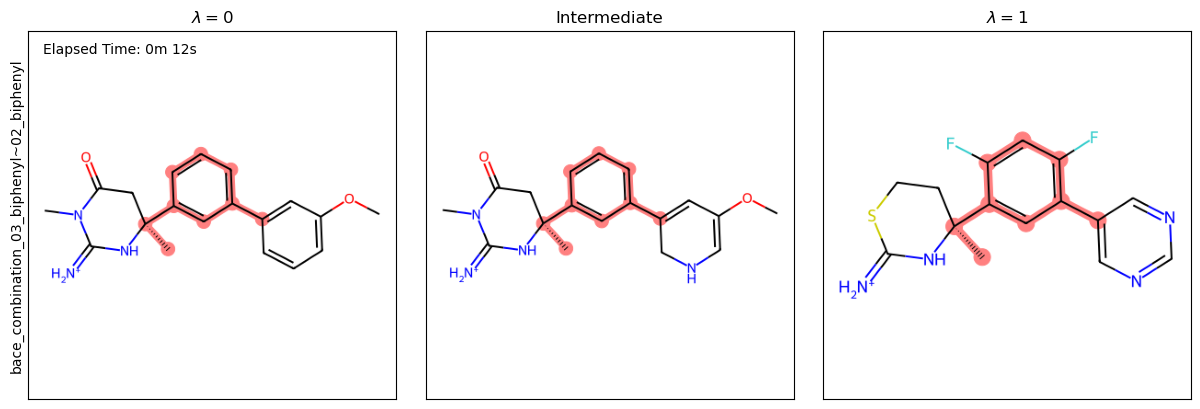

In [4]:
for tgt, pert in perts_to_intrap:
    
    # insert time stamp
    start_time = time.time()    
    
    # get the endpoint molecular objects.
    liga, ligb = pert.split("~")
    try:
        liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"ligands/{tgt}/{lig}.sdf")[0] for lig in [liga, ligb]]
    except OSError:
        # naming is inconsistent; try with 'lig_' prefix.
        liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"ligands/{tgt}/lig_{lig}.sdf")[0] for lig in [liga, ligb]]
        
    liga_smiles = Chem.MolToSmiles(liga)
    ligb_smiles = Chem.MolToSmiles(ligb)

    # generate multiple paths
    generated_paths = generation.generate_multiple_paths(liga_smiles, ligb_smiles, num_tries, num_random_smiles, collect_bidirectional, n_rounds=n_rounds, fp_type=fp_type)
    
    # generate local subspace of molecules 
    generated_mols = generation.generate_chemical_space(liga_smiles, ligb_smiles, generated_paths, num_random_samples, num_mutation_ls, fp_type=fp_type)
        
    # score molecules
    sorted_smiles_dict = scoring.score_molecules_lomap_tanimoto(liga_smiles, ligb_smiles, generated_mols)

    # select the final smiles string
    selected_intermediate = next(iter(sorted_smiles_dict))
    
    # stop the timer and calculate the elapsed time
    elapsed_time = time.time() - start_time
    # convert elapsed time to minutes and seconds
    mins, secs = divmod(elapsed_time, 60)
    
    # Create a filename using tgt and pert
    filename = f'{tgt}_{pert}'
    filepath = f'{base_dir}/{filename}'

    
    # visualize triplet
    visualization.visualise(liga_smiles, ligb_smiles, selected_intermediate, mins, secs, filepath, filename)